In [1]:
import requests
import json

In [2]:
apikey = "WFWJxIoLy5DwlwuThYH-ylzgn215LIBZ6LCLGqsFCq0"

In [3]:
BASE_URL = 'https://www.deribit.com/api/v2/'

ENDPOINT = 'public/get_order_book'

In [4]:
def make_request(endpoint, params=None):
    headers = {
        'Authorization': f'Bearer {apikey}',
    }
    response = requests.get(BASE_URL + endpoint, params=params, headers=headers)
    return response.json()

# Function to fetch order book data
def get_order_book(instrument, depth=10):
    params = {
        'instrument_name': instrument,
        'depth': depth
    }
    response = make_request(ENDPOINT, params)
    return response

# Example usage
if __name__ == "__main__":
    instrument_name = 'BTC-PERPETUAL'
    order_book = get_order_book(instrument_name)
    print(json.dumps(order_book, indent=4))

{
    "jsonrpc": "2.0",
    "result": {
        "funding_8h": -5.36e-06,
        "current_funding": 0.0,
        "estimated_delivery_price": 63992.4,
        "best_bid_amount": 252250.0,
        "best_ask_amount": 70.0,
        "best_bid_price": 63978.5,
        "best_ask_price": 63979.0,
        "interest_value": -0.014768950062225606,
        "open_interest": 786827530,
        "max_price": 65900.5,
        "min_price": 62061.5,
        "last_price": 63978.5,
        "asks": [
            [
                63979.0,
                70.0
            ],
            [
                63983.5,
                260.0
            ],
            [
                63986.5,
                2000.0
            ],
            [
                63987.0,
                7510.0
            ],
            [
                63987.5,
                9880.0
            ],
            [
                63990.0,
                350.0
            ],
            [
                63990.5,
                751

In [48]:
import pandas as pd
from pandas import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm

import datetime as dt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title('Bitcoin Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label, cmap='viridis')
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

In [6]:
%%time

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options():
    import urllib.request, json
    url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [12]:

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]
    
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')
    
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

In [13]:
# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = json_normalize(data['result'])
    data.index = [instrument_name]
    return data


In [14]:
def get_all_option_data():
    option_data = get_tick_data('BTC-PERPETUAL')
    price = option_data.at['BTC-PERPETUAL', 'last_price']
    options = filter_options(price, get_all_active_options())
    data_list = [option_data]  # Start with initial option data

    # Retrieve tick data for each option and add to the list
    for o in options.index:
        tick_data = get_tick_data(o)
        data_list.append(tick_data)

    # Concatenate all DataFrame objects in the list
    option_data = pd.concat(data_list)
    return option_data


In [16]:


def get_all_option_data():
    # Assume get_tick_data and filter_options are defined correctly as they fetch and process data
    option_data = get_tick_data('BTC-PERPETUAL')
    price = option_data.at['BTC-PERPETUAL', 'last_price']
    options = filter_options(price, get_all_active_options())
    data_list = [option_data]  # Start with initial option data

    # Retrieve tick data for each option and add to the list
    for o in options.index:
        tick_data = get_tick_data(o)
        data_list.append(tick_data)

    # Concatenate all DataFrame objects in the list
    option_data = pd.concat(data_list)
    return option_data

# Get data
option_data = get_all_option_data()

# Initialize additional columns
option_data['t'] = np.nan
option_data['strike'] = np.nan

# Ensure you start processing from the first option onward (ignoring 'BTC-PERPETUAL' at index 0)
# Adjust indexing method to use .iloc for integer location based operations
try:
    expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), format='%Y%m%d', errors='coerce')
    days_until_expiration = (expiration_dates - pd.Timestamp.today()).days
    option_data.iloc[1:, option_data.columns.get_loc('t')] = days_until_expiration
except Exception as e:
    print(f"Error processing expiration dates: {e}")

try:
    strikes = option_data.iloc[1:].index.map(lambda x: x.split('-')[2]).astype(int)
    option_data.iloc[1:, option_data.columns.get_loc('strike')] = strikes
except Exception as e:
    print(f"Error processing strike prices: {e}")

# Calculate "moneyness"
try:
    if not option_data.empty and 'last_price' in option_data.columns:
        first_price = option_data.iloc[0]['last_price']  # Assumes the first index is 'BTC-PERPETUAL'
        option_data['m'] = np.log(first_price / option_data['strike'])
except ZeroDivisionError:
    print("Division by zero encountered in 'moneyness' calculation.")
except Exception as e:
    print(f"Error during 'moneyness' calculation: {e}")


942 active options.
217 active options after filter.


/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/1687637804.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat(data_list)


In [62]:
# Calculated days until expiration
# Assuming option_data's index contains the date information in the second segment after splitting by '-'
expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), errors='coerce')
# Calculate the days directly from the TimedeltaIndex
days_until_expiration = (expiration_dates - pd.Timestamp.today()).days
option_data.iloc[1:, option_data.columns.get_loc('t')] = days_until_expiration

# Pull strike from instrument name
# Assuming option_data's index contains the strike price information in the third segment after splitting by '-'
option_data.iloc[1:, option_data.columns.get_loc('strike')] = option_data.iloc[1:].index.map(lambda x: x.split('-')[2]).astype(int)

# Calculate "moneyness"
# Assuming 'last_price' is stored in the DataFrame and is consistent across the DataFrame
if 'last_price' in option_data.columns:
    first_price = option_data.iloc[0]['last_price']  # Correctly using .iloc to access the first row
    option_data['m'] = np.log(first_price / option_data['strike'])
else:
    print("Error: 'last_price' not found in option_data columns.")


/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/4243206360.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  expiration_dates = pd.to_datetime(option_data.iloc[1:].index.map(lambda x: x.split('-')[1]), errors='coerce')


In [63]:
option_data

,funding_8h,current_funding,estimated_delivery_price,best_bid_amount,best_ask_amount,best_bid_price,best_ask_price,interest_value,open_interest,max_price,...,interest_rate,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,t,strike,m,iv_adj
BTC-PERPETUAL,-0.000005,0.0,64006.71,19690.0,156240.0,64008.5000,64009.0000,-0.014769,786913730.0,65922.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BTC-25APR24-58000-P,NaN,NaN,64006.90,0.0,5.0,0.0000,0.0001,NaN,30.5,0.0170,...,0.0,-0.00174,-1.75786,0.16484,0.00000,-0.00257,0.0,58000.0,0.098401,109.725557
BTC-25APR24-59000-P,NaN,NaN,64007.63,0.0,19.8,0.0000,0.0003,NaN,44.5,0.0185,...,0.0,-0.00300,-2.81054,0.26929,0.00001,-0.00444,0.0,59000.0,0.081307,96.916052
BTC-25APR24-60000-P,NaN,NaN,64009.15,0.0,0.3,0.0000,0.0002,NaN,49.4,0.0200,...,0.0,-0.00565,-4.88128,0.47181,0.00001,-0.00837,0.0,60000.0,0.064499,84.122453
BTC-25APR24-61000-P,NaN,NaN,64010.50,13.0,0.5,0.0001,0.0003,NaN,31.2,0.0230,...,0.0,-0.01391,-11.62845,1.02789,0.00003,-0.02062,0.0,61000.0,0.047970,73.471613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BTC-28JUN24-65000-C,NaN,NaN,64016.83,4.3,14.4,0.1065,0.1080,NaN,3447.2,0.1715,...,0.0,51.36090,-53.47343,107.97860,0.00002,0.55450,64.0,65000.0,-0.015543,58.353529
BTC-28JUN24-70000-C,NaN,NaN,64030.86,4.3,30.6,0.0760,0.0775,NaN,2796.8,0.1395,...,0.0,42.18393,-53.34639,107.91932,0.00002,0.44408,64.0,70000.0,-0.089651,59.331797
BTC-28JUN24-75000-C,NaN,NaN,64030.86,26.2,20.5,0.0535,0.0550,NaN,4673.9,0.1140,...,0.0,33.50960,-50.06660,100.79250,0.00002,0.34624,64.0,75000.0,-0.158644,60.355126
BTC-28JUN24-80000-C,NaN,NaN,64034.68,10.7,12.8,0.0380,0.0390,NaN,2561.9,0.0940,...,0.0,26.06863,-44.94439,89.60709,0.00002,0.26559,64.0,80000.0,-0.223183,61.426576


/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/4038683468.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = (option_data['last_price'][0]/option_data_['strike'])


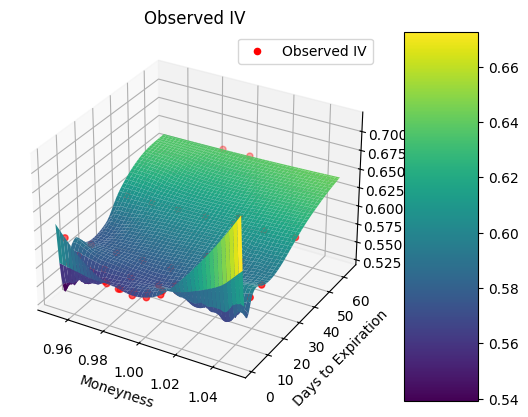

In [64]:
# Interpolate implied volatility using a cubic spline
# Then plot the implied volatility surface

option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))

/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/2002118152.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_diff = option_data['mark_price'][0]-option_data['underlying_price']


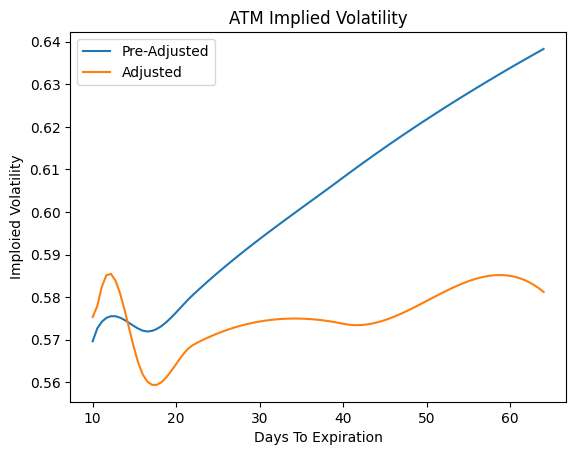

In [65]:
price_diff = option_data['mark_price'][0]-option_data['underlying_price']
option_data['iv_adj'] = option_data['mark_iv']+(option_data['greeks.delta']*price_diff)/(option_data['greeks.vega'])
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')

Z = interpolate.griddata(np.array([x,y]).T,np.array(option_data_['iv_adj']/100),(X,Y), method='cubic')
iv_df_adj = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))
iv_df.loc[:,1].plot(label='Pre-Adjusted')
(iv_df_adj.loc[:,1]).plot(label='Adjusted')
plt.xlabel('Days To Expiration')
plt.ylabel('Imploied Volatility')
plt.legend()
plt.title('ATM Implied Volatility')
plt.show()

/Users/aryanhemani/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


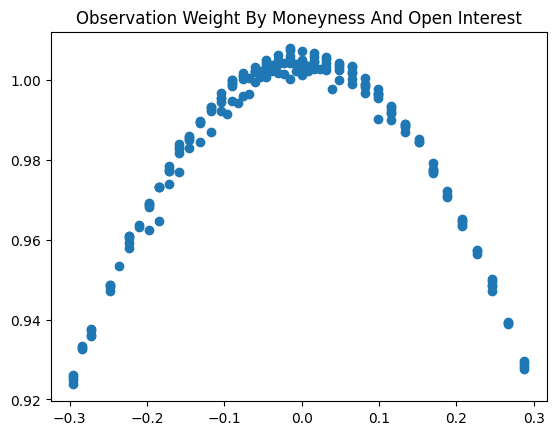

In [66]:
weights = 1/(1+((option_data_['m']**2)))+((np.log(option_data_['open_interest']).replace(-np.inf,0)/np.log(option_data_['open_interest']).replace(-np.inf,0).sum()))
plt.scatter(option_data_['m'],weights)
plt.title('Observation Weight By Moneyness And Open Interest')
plt.show()

In [67]:
option_data_reg = option_data.iloc[1:].sort_values(['t','strike'])
t = np.sqrt(option_data_['t']/365)
m = np.log(option_data['last_price'][0]/option_data_['strike'])/t
X = pd.DataFrame({'M':m,'M2':m**2,'M3':m**3,'t':t,'tM':t*m,'t2':t**2})
y = (option_data_['iv_adj']/100)

X = sm.add_constant(X) 
model = sm.WLS(y, X, weights=weights).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                 iv_adj   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     262.7
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           7.88e-87
Time:                        16:09:21   Log-Likelihood:                 251.79
No. Observations:                 189   AIC:                            -489.6
Df Residuals:                     182   BIC:                            -466.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6924      0.018     39.320      0.0

/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/32180863.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = np.log(option_data['last_price'][0]/option_data_['strike'])/t


/var/folders/x1/w7v_rb6x76b1ltfzphz5s_900000gn/T/ipykernel_45002/1819888550.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = (option_data['last_price'][0]/option_data_['strike'])


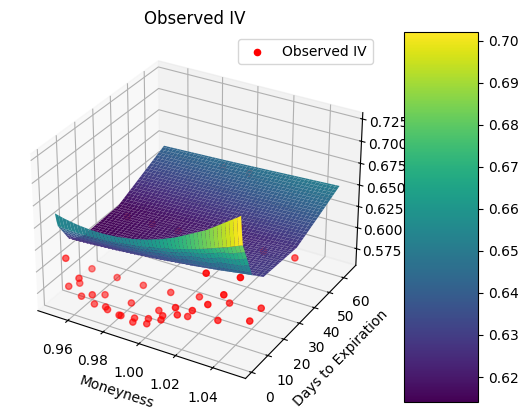

In [68]:
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = model.predict(X)

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='linear')

xyz = pd.DataFrame({'x':x,'y':y,'z':(option_data_['mark_iv']/100)})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df_fit = pd.DataFrame(Z, index=np.linspace(5,np.max(y),100), columns=np.linspace(.95,1.05,99))

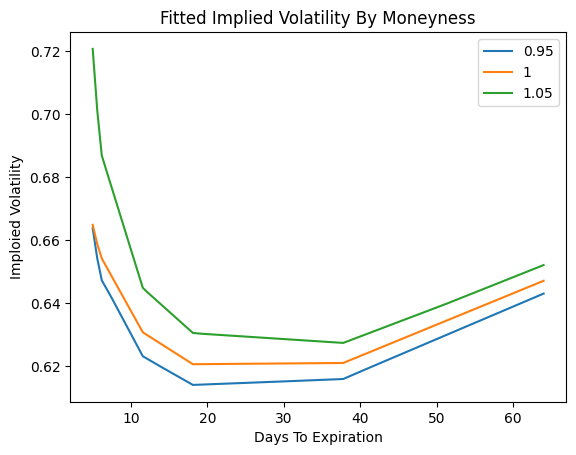

In [69]:
plt.plot(iv_df_fit.loc[:,[.95,1,1.05]])
plt.xlabel('Days To Expiration')
plt.ylabel('Imploied Volatility')
plt.legend(['0.95','1','1.05'])
plt.title('Fitted Implied Volatility By Moneyness')
plt.show()
